Основа через бинаризацию 

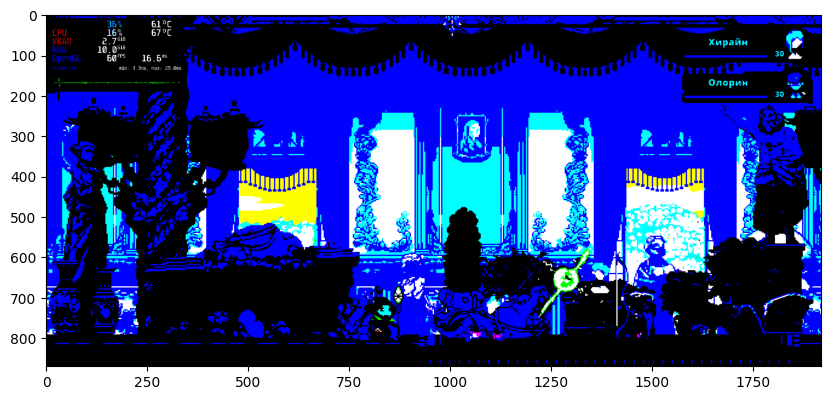

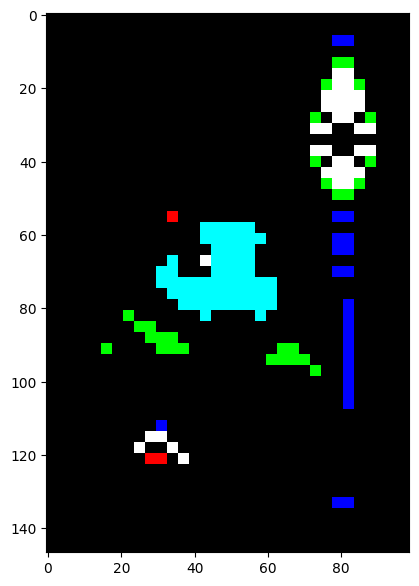

0.5174025297164917
не нашел


In [179]:
import cv2
from matplotlib import pyplot as plt
import numpy as no

image = cv2.imread('screens/ikran6.png')[:870, :]
template = cv2.imread('sprites/Alchemist_Sprite.png')

image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)

ret1, th1 = cv2.threshold(image, 191, 255, cv2.THRESH_BINARY)
ret2, th2 = cv2.threshold(template, 191, 255, cv2.THRESH_BINARY)

fig = plt.figure(figsize=(10, 7))
plt.imshow(th1)
plt.show()
fig = plt.figure(figsize=(10, 7))
plt.imshow(th2)
plt.show()

#TM_CCOEFF, TM_CCOEFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_SQDIFF, TM_SQDIFF_NORMED
result = cv2.matchTemplate(th1, th2, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
threshold = 0.7
w, h = template.shape[1], template.shape[0]
print(max_val)
if max_val >= threshold:
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right,
                    color=(0, 255, 0), thickness=2, lineType=cv2.LINE_4)
    fig = plt.figure(figsize=(10, 7))
    plt.imshow(image)
    plt.show()
else:
    print('не нашел')


Функция перебора параметров (щас на Кенни)

In [51]:
def thresh(img, tmp):
    lst = [i for i in range(1,300+20,10)]
    res = []
    edg = []
    for x in lst:
        edg.append(x)
        edges_image = cv2.Canny(image, x, 355)
        edges_template = cv2.Canny(tmp, x,355)
        result = cv2.matchTemplate(edges_image, edges_template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        #print(max_val)
        res.append(max_val*100)
        threshold = 0.9
        w, h = template.shape[1], template.shape[0]
        if max_val >= threshold:
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(img, top_left, bottom_right,
                            color=(0, 255, 0), thickness=2, lineType=cv2.LINE_4)
    plt.plot(edg, res)
    plt.ylabel('%')
    plt.xlabel('x')
    plt.show()

Запуск перебора

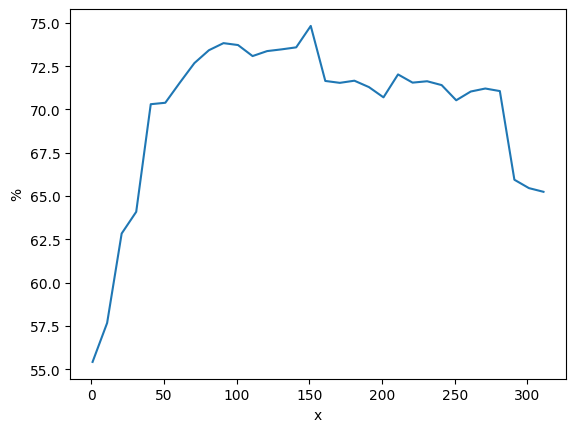

In [55]:
import cv2
image = cv2.imread('screens/ikran6.png', cv2.IMREAD_GRAYSCALE)[:870, :]
template = cv2.imread('sprites/Alchemist_Sprite.png', cv2.IMREAD_GRAYSCALE)

thresh(image, template)

Перебор методов поиска соответствия на фотке

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
original = cv.imread('screens/ikran4.png')[:870, :]
orig = original.copy()
img = cv.imread('screens/ikran4.png')[:870, :]
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, img = ret1,th1 = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
img2 = img.copy()
template = cv.imread('sprites/Alchemist_Sprite.png')
template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
_, template = cv2.threshold(template,50,255,cv2.THRESH_BINARY)
w, h = template.shape[1], template.shape[0]
# All the 3 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR_NORMED','cv.TM_CCORR','cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    original = orig.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print(f"meth={meth} , min_val={min_val}, max_val={max_val}, min_loc={min_loc}, max_loc={max_loc}")

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = min_loc#max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(original,top_left, bottom_right, 255, 2)
    fig = plt.figure(figsize=(10, 7))
    plt.imshow(original)
    plt.show()